## Imports

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

Defining the hyperparameters for use in the function calls in the rest of this notebook

In [ ]:
n_variables = 4
temperature = 10
percent_bounds = 0.1
lower_bound = np.array([0.125, 0.125, 0.1, 0.1])
upper_bound = np.array([5.0, 5.0, 10.0, 10.0])
# constraint handling parameters
r = 20
beta = 1
inf = 1000000

## Task 1 - implement functions

In [ ]:
def objective_function(x):
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]
  x4 = x[3]

  calculation = 1.10471*(x1**2)*x2 + 0.04811*x3*x4*(14.0 + x2)
  objective_function.count += 1
  return calculation

In [ ]:
def tau_prime_one(x):
  x1 = x[0]
  x2 = x[1]

  calculation = (6000)/(np.sqrt(2)*x1*x2)
  return calculation

In [ ]:
def tau_prime_two(x):
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]

  calculation = ((6000*(14+0.5*x2)*np.sqrt(0.25*(x2**2 + (x1 + x3)**2))) / 
                      (2*((0.707*x1*x2)*(((x2**2)/12)+0.25*((x1+x3)**2)))))
  return calculation

In [ ]:
def shear_stress(x):
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]

  calculation = np.sqrt(
      ((tau_prime_one(x)**2) + (tau_prime_two(x)**2)) + 
      ((x2*tau_prime_one(x)*tau_prime_two(x)) /
      (np.sqrt(0.25*(x2**2 + (x1 + x3)**2))))
      )
  return calculation


In [ ]:
def normal_stress(x):
  x3 = x[2]
  x4 = x[3]

  calculation = 504000/((x3**2)*x4)
  return calculation
  

In [ ]:
def buckling_load(x):
  x3 = x[2]
  x4 = x[3]

  calculation = 64746.022*(1-0.0282346*x3)*x3*x4**3
  return calculation


In [ ]:
def g1(x):
  calc = 13600 - shear_stress(x)
  g1.count += 1
  return calc

In [ ]:
def g2(x):
  calc = 30000 - normal_stress(x)
  g2.count += 1
  return calc

In [ ]:
def g3(x):
  x1 = x[0]
  x4 = x[3]

  calc = x4 - x1
  g3.count += 1
  return calc

In [ ]:
def g4(x):
  calc = buckling_load(x) - 6000
  g4.count += 1
  return calc

## Supporting Functions

In [ ]:
def reset_counters():
  objective_function.count = 0
  g1.count = 0
  g2.count = 0
  g3.count = 0
  g4.count = 0

In [ ]:
def constraints_met(x):
  # each index corresponds to a constraint and if it is met ([0] = g1())
  # start by assuming no constraints are met
  truth_arr = np.array([False, False, False, False])

  # if a constraint is met the corresponding index in truth_arr is updated
  if(g1(x) >= 0):
    truth_arr[0] = True 
  if(g2(x) >= 0):
    truth_arr[1] = True 
  if(g3(x) >= 0):
    truth_arr[2] = True 
  if(g4(x) >= 0):
    truth_arr[3] = True 

  return truth_arr


In [ ]:
# returns False if any value is out of bounds
def bounds_met(x, lower_bound, upper_bound):
  for x_index in range(4):
    if (x[x_index] <= lower_bound[x_index] or x[x_index] >= upper_bound[x_index] ):
      return False

  return True

## Functions Test

In [ ]:
reset_counters()
x = np.array([1.05, 3.15, 4.43, 7.87])

print("Objective funtion output: ", objective_function(x))
print("First constraint funtion output: ", g1(x))
print("Second constraint funtion output: ", g2(x))
print("Third constraint funtion output: ", g3(x))
print("Fourth constraint funtion output: ", g4(x))


Objective funtion output:  32.6024179859
First constraint funtion output:  5308.848564674312
Second constraint funtion output:  26736.764990548952
Third constraint funtion output:  6.82
Fourth constraint funtion output:  122317448.61430933


## Task 2 - Random Search

In [ ]:
def death_penalty(x, inf):
  constraints = constraints_met(x)
  output = objective_function(x)

  # if any constraints are voilated the death penalty is issued
  if np.all(constraints):
    return output
  else:
    return inf 


In [ ]:
# random search implemented with death penalty constraint handling
def random_search(k, lower_bound, upper_bound, inf, n_variables, seed):
  # random generator based on seed
  rng = np.random.RandomState(seed)
  best_x = rng.uniform(lower_bound, upper_bound, n_variables)
  best_f = death_penalty(best_x, inf)

  for sample in range(0,k):
    candidate_x = rng.uniform(lower_bound, upper_bound, n_variables)
    # constraint handling with death penalty
    candidate_f = death_penalty(candidate_x, inf) 
    # print(candidate_x)

    if(candidate_f < best_f):
      best_x = candidate_x
      best_f = candidate_f
  
  return [best_x[0], best_x[1], best_x[2], best_x[3], best_f]

## Task 3 - Simulated Annealing

In [ ]:
def static_penalty(x, r, beta):
  constraints = constraints_met(x)

  # initialise with assuming no penalty and normal function
  penalty_applied = objective_function(x)

  # if a constraint is violated add the penalty of that constraint to the objective
  if constraints[0] == False:
    penalty_applied += static_function(x[0], g1(x), r, beta)
  if constraints[1] == False:
    penalty_applied += static_function(x[1], g2(x), r, beta)
  if constraints[2] == False:
    penalty_applied += static_function(x[2], g3(x), r, beta)
  if constraints[3] == False:
    penalty_applied += static_function(x[3], g4(x), r, beta)
    
  return penalty_applied



In [ ]:
# simulated annealing implemented with static penalty constraint handling
def simulated_annealing(n_iterations, lower_bound, upper_bound, percent_bounds, 
                        r, beta, n_variables, temp, seed):
  # random generator based on seed
  rng = np.random.RandomState(seed)
  best_x = rng.uniform(lower_bound, upper_bound, n_variables)
  best_f = static_penalty(best_x, r, beta)
  candidate_x = best_x
  candidate_f = best_f

  for i in range(0, n_iterations):
      prime_x = transition_distribution(candidate_x, lower_bound, upper_bound, 
                                        percent_bounds, n_variables, rng)
      # constraint handling by static_penalty, 
      # acts like objective function if constraints not violated
      prime_f = static_penalty(prime_x, r, beta)
      change = prime_f - candidate_f

      # using logarithmic decay
      if (change <= 0) or (rng.uniform(0,1) < min(np.exp(-change/temp),1)):
        candidate_x = prime_x
        candidate_f = prime_f

      if prime_f < best_f:
        best_x = prime_x
        best_f = prime_f

  return [best_x[0], best_x[1], best_x[2], best_x[3], best_f]


In [ ]:
def transition_distribution(mean, lower_bound, upper_bound, percent_bounds, n_variables, rng):
  local_bounds = np.zeros(n_variables)

  for i in range(len(lower_bound)):
    local_bounds[i] = (upper_bound[i] - lower_bound[i]) * percent_bounds

  covariance = np.array([[local_bounds[0], 0, 0, 0], 
                         [0, local_bounds[1], 0, 0], 
                         [0, 0, local_bounds[2], 0], 
                         [0, 0, 0, local_bounds[3]]])
  
  # initial attempt
  random_result = rng.multivariate_normal(mean, covariance)
  within_bounds = bounds_met(random_result, lower_bound, upper_bound)

  # rejection sampling, quite inefficient but no multivariate truncnorm :/
  while(within_bounds == False):
    # trying again if sample is out of bounds
    random_result = rng.multivariate_normal(mean, covariance)
    within_bounds = bounds_met(random_result, lower_bound, upper_bound)

  # found sample within bounds
  return random_result

In [ ]:
def static_function(point, constraint_applied, r, beta):
  # absolute (positive) value of the constraint result is used 
  # this is because we want our objective function to get larger
  # when our constraint output is LESS than 0 (not met)
  return (r * max(0, abs(constraint_applied))**beta)

## Task 4 - Evaluation

Showing that function evaluations do not exceed 10000 for a single run when k = 5000

In [ ]:
# number of iterations for both optimisers
k = 5000
# generate random seed between reasonable bounds
seed = np.random.randint(100000)

'''
The reason i picked k = 5000 is because, due to my implementation of static 
penalty, it is theoretically possible that my simulated annealing algorithm 
could evaluate a constraint 2k times but it is super unlikely.
'''

# function evaluation counters set to 0
reset_counters()

print("RS result: ", random_search(k, lower_bound, upper_bound, inf, n_variables, seed))

print ("Objective function evaluations: ", objective_function.count)
print ("Constraint g1(x) evaluations: ", g1.count)
print ("Constraint g2(x) evaluations: ", g2.count)
print ("Constraint g3(x) evaluations: ", g3.count)
print ("Constraint g4(x) evaluations: ", g4.count)
print("\n")

# function evaluation counters set to 0
reset_counters()

print("SA result: ", simulated_annealing(k, lower_bound, upper_bound, percent_bounds, 
                                         r, beta, n_variables, temperature, seed))

print ("Objective function evaluations: ", objective_function.count)
print ("Constraint g1(x) evaluations: ", g1.count)
print ("Constraint g2(x) evaluations: ", g2.count)
print ("Constraint g3(x) evaluations: ", g3.count)
print ("Constraint g4(x) evaluations: ", g4.count)

RS result:  [0.6858644326800653, 2.3509537549684625, 8.30456348099789, 0.7803670635743349, 6.3196460220452835]
Objective function evaluations:  5001
Constraint g1(x) evaluations:  5001
Constraint g2(x) evaluations:  5001
Constraint g3(x) evaluations:  5001
Constraint g4(x) evaluations:  5001


SA result:  [0.4202373560310514, 2.9711505828970144, 8.85856234127392, 0.4963688310768032, 4.169810084672065]
Objective function evaluations:  5001
Constraint g1(x) evaluations:  6040
Constraint g2(x) evaluations:  5598
Constraint g3(x) evaluations:  5968
Constraint g4(x) evaluations:  5061


**Run experiment and gather results for each optimiser**

In [ ]:
n_repeats = 21
# used for generating a random seed on each run
n_possible_seeds = 100000
# run random searches and print best result
rand_results = []
for i in range(n_repeats):
  rand_results.append(random_search(k, lower_bound, upper_bound, inf, n_variables,  
                                    np.random.randint(n_possible_seeds))[4])
print("best random search: ", min(rand_results))

anneal_results = []
for i in range(n_repeats):
  anneal_results.append(simulated_annealing(k, lower_bound, upper_bound, percent_bounds, r, beta,
                                            n_variables, temperature, np.random.randint(n_possible_seeds))[4])
print("best annealing: ", min(anneal_results))


best random search:  3.4017898285473867
best annealing:  3.150105307660348


**Boxplot**

Text(0, 0.5, 'Best Objective Value')

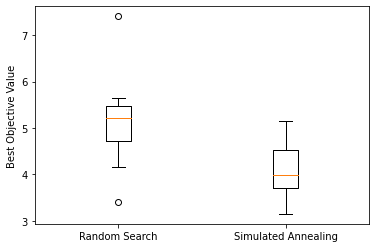

In [ ]:
plt.boxplot([rand_results, anneal_results])
plt.xticks([1,2], ['Random Search', 'Simulated Annealing'])
plt.ylabel("Best Objective Value")

The assumptions I am making for my analysis are:
*   The results for each optimiser are normally distributed
*   The results for RS(Random Search) and SA(Simulated Annealing) are independent
*   The starting points for the *i*th run of RS is the same as the starting point for the *i*th run of SA (they are matched)


From these assumptions and observing the boxplot a few naive observations that can be made are:
*   On average, SA produces a better objective value than RS
*   RS will sometimes outperform SA
*   Because the mean for SA is better than RS, if given the choice, SA should be used over RS

However, both of these optimisers are **stochastic** so these conclusions **cannot** be certain. I will carry out a statistical test to determine the significance of my findings and find the likelyhood that my conclusions are correct.


**Hypothesis testing**

Because the results of each optimiser are independent of one another, I am going to perform an un-paired mannwhitneyu test to find if there is statistical significance between the performance of random search and simulated annealing.

Let the null hypothesis be that there is no difference between the performance of the optimisers: <br>
>$p(RS(x)) = p(SA(x))$ <br> where $p() = performance$ measured by the distribution (mean and variance) of best objective values from 21 runs of the optimiser

The alternate hypothesis is that the performance of simulated annealing is greater than that of random search:
>$p(RS(x)) < p(SA(x))$

For this test i assume $α = 0.025$ for a one-tailed test

In [ ]:
# carry out Mann-Whitney U test and find p value
U1, p = stats.mannwhitneyu(anneal_results, rand_results, alternative = "less")
print(p)

9.493758016944358e-06


$ 9.494 \times 10^{-5} < α$ <br>
Therefore, we can **reject** the null hypothesis and can say with some confidence that when applied to the same probelm **SA** will likely perform **better** than **RS** and thus **SA** should be chosen.

## Task3/4 - Proof seeding works

In [ ]:
seed = 1
print("Random search repeated twice using seed = 1:")
print(random_search(k, lower_bound, upper_bound, inf, n_variables, seed))
print(random_search(k, lower_bound, upper_bound, inf, n_variables, seed))

print("Simulated annealing repeated twice using seed = 1:")
print(simulated_annealing(k, lower_bound, upper_bound, percent_bounds, r, beta, 
                    n_variables, temperature, seed))
print(simulated_annealing(k, lower_bound, upper_bound, percent_bounds, r, beta, 
                    n_variables, temperature, seed))

seed = 2
print("Random search repeated twice using seed = 2:")
print(random_search(k, lower_bound, upper_bound, inf, n_variables, seed))
print(random_search(k, lower_bound, upper_bound, inf, n_variables, seed))

print("Simulated annealing repeated twice using seed = 2:")
print(simulated_annealing(k, lower_bound, upper_bound, percent_bounds, r, beta, 
                    n_variables, temperature, seed))
print(simulated_annealing(k, lower_bound, upper_bound, percent_bounds, r, beta, 
                    n_variables, temperature, seed))

Random search repeated twice using seed = 1:
[0.5307913953317545, 4.8279379517070895, 5.0547394018232925, 0.8140562152485146, 5.2299232517034335]
[0.5307913953317545, 4.8279379517070895, 5.0547394018232925, 0.8140562152485146, 5.2299232517034335]
Simulated annealing repeated twice using seed = 1:
[0.5356653162548561, 4.038817671424623, 5.841980431534224, 0.5337909990230916, 4.024013749230915]
[0.5356653162548561, 4.038817671424623, 5.841980431534224, 0.5337909990230916, 4.024013749230915]
Random search repeated twice using seed = 2:
[0.33680620539582484, 3.962473741410996, 9.469963393879167, 0.46347208554408337, 4.289480971286838]
[0.33680620539582484, 3.962473741410996, 9.469963393879167, 0.46347208554408337, 4.289480971286838]
Simulated annealing repeated twice using seed = 2:
[0.4651461106375443, 3.399541892892194, 6.96749128977918, 0.6099745025461076, 4.3701792537021875]
[0.4651461106375443, 3.399541892892194, 6.96749128977918, 0.6099745025461076, 4.3701792537021875]
